# iForest

In [1]:
import warnings
warnings.filterwarnings('ignore')

## General libraries

In [2]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from os.path import join
import json
import datetime

import shap
from shap_selection import feature_selection

from sklearn.preprocessing import OneHotEncoder
import time

### Load enviroment variables

In [3]:
from dotenv import load_dotenv
load_dotenv('../.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.load.functions import get_fs_dataset, fs_datasets_hyperparams
from src.plots.functions import plot_3d_surface, plot_2d_surface, boxplot_stability, lineplot_stability
from src.utils.functions import add_custom_repeating_sequence, add_sequence_to_dataframe, prepare_subsets
from src.optimization.functions import opt_value

# if we want to create an iteractive plot or not
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

## Parameters

In [5]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


def process_data(dataset_id, data_root):
    """
    Processes SHAP data files by reading them, filtering, and calculating additional metrics.
    
    Parameters:
    - dataset_id: The unique identifier for the dataset.
    - data_root: The root directory where the data files are located.
    
    Returns:
    - df: The processed pandas DataFrame containing selected variables and calculated metrics.
    """
    # Construct file paths
    path_shap = os.path.join(data_root, "outputs", f"{dataset_id}_shap.parquet")
    path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
    
    # Read data
    df = pd.read_parquet(path_shap)
    fi_shap_all = pd.read_parquet(path_fi_shap)  # Note: fi_shap_all is read but not used in the provided code
    
    # Filter dataframe
    df = df[(df.n_estimators >= 25) & (df.n_estimators <= 300)]
    
    # Calculate percentiles and stability index
    df['shap_q1'] = df['shap_stab'].apply(lambda x: np.percentile(x, 75))
    df['shap_q2'] = df['shap_stab'].apply(lambda x: np.percentile(x, 50))
    df['shap_q3'] = df['shap_stab'].apply(lambda x: np.percentile(x, 25))
    df['shap_ad_q2'] = df['shap_stab_ad'].apply(lambda x: np.percentile(x, 50))
    df['stability index'] = df['shap_stab'].apply(lambda x: np.mean(x))
    df['dataset'] = dataset_id
    df['hpo'] = np.where((df.n_estimators == 100) & (df.max_feats == df.max_feats.max()),
        'Benchmark',
        'Our model')
    # Select variables to keep
    var = ['dataset', 'hpo', 'n_estimators', 'max_feats', 'n_feats', 'f1_median', 'precision', 'recall', 'model_stab', 'shap_stab', 'shap_q2', 'stability index', 'roc_auc']
    df = df[var]

    return df


def filter_and_select(df, boxplot=False, factor=0.99):
    """
    Filters and selects rows from a DataFrame based on specified conditions.
    
    Parameters:
    - df: A pandas DataFrame containing model evaluation metrics and parameters.
    
    Returns:
    - df_filtered: A filtered DataFrame based on the conditions.
    """
    # Define the variables of interest
    var = ['dataset', 'hpo', 'n_estimators', 'n_feats', 'max_feats', 'roc_auc', 'precision', 'recall', 'f1_median', 'stability index', 'shap_stab']
    df = df[var]

    df1_1 = df[df.hpo == 'Benchmark'].head(1)
    # Extract specific metrics from df1_1
    roc = df1_1.roc_auc.iloc[0] * factor
    precision = df1_1.precision.iloc[0] * factor
    recall = df1_1.recall.iloc[0] * factor
    f1_median = df1_1.f1_median.iloc[0] * factor
    stability = df1_1['stability index'].iloc[0]

    baseline = {'f1_median': f1_median, 'precision': precision, 'recall': recall, 'roc_auc': roc}
    df1_2 = df[df.hpo != 'Benchmark']
    criteria = np.where(df1_1.n_feats>=20, False, True)
    df1_2 = df1_2[df1_2['stability index'] >= stability]
    df1_2 = find_best_row_by_distance_and_stability(df1_2, 
                                                    baseline, 
                                                    stability_col='stability index', 
                                                    distance_weight=1, 
                                                    stability_weight=0.3, 
                                                    threshold=np.inf,
                                                    prefer_higher_than_baseline=criteria)

    # Extract specific feature numbers
    dataframes = [df1_1, df1_2]
    df = pd.concat(dataframes)
    #df = df.drop_duplicates()

    return df


def find_best_row_by_distance_and_stability(df, baseline, stability_col='stability', distance_weight=1, stability_weight=0.5, threshold=np.inf, prefer_higher_than_baseline=False):
    """
    Finds the best matching row in df based on a combination of closeness to the baseline values, the stability score, and optionally preferring rows with values higher than the baseline.
    
    Parameters:
    - df: DataFrame to search within.
    - baseline: Dictionary specifying baseline values for columns, excluding the stability column.
    - stability_col: Name of the column containing stability scores.
    - distance_weight: Weight of the distance score in the final score calculation.
    - stability_weight: Weight of the stability score in the final score calculation.
    - threshold: Maximum allowed final score to consider a row close enough.
    - prefer_higher_than_baseline: Boolean flag to prefer rows with all values higher than the baseline before considering distance and stability.
    
    Returns:
    - A single-row DataFrame if a suitable row is found; otherwise, None.
    """
    if df.empty:
        return None

    # Check for missing columns
    missing_cols = [col for col in baseline.keys() if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing columns in DataFrame: {missing_cols}")
    if stability_col not in df.columns:
        raise ValueError(f"Missing stability column '{stability_col}' in DataFrame")

    # Filtering rows higher than the baseline if preferred
    if prefer_higher_than_baseline:
        higher_than_baseline = df.apply(lambda row: all(row[col] > baseline[col] for col in baseline), axis=1)
        if higher_than_baseline.any():
            df = df[higher_than_baseline]

    # Compute the "distance" for each row
    distance = df.apply(lambda row: np.sqrt(sum((row[baseline.keys()] - pd.Series(baseline))**2)), axis=1)

    # Normalize distance and stability scores to [0, 1]
    distance_norm = (distance - distance.min()) / (distance.max() - distance.min())
    stability_norm = (df[stability_col] - df[stability_col].min()) / (df[stability_col].max() - df[stability_col].min())

    # Calculate combined score
    final_score = distance_weight * distance_norm - stability_weight * stability_norm

    # Find the row with the minimum final score
    best_idx = final_score.idxmin()

    # Return the best row if the score is within the threshold
    if final_score[best_idx] <= threshold:
        return df.loc[[best_idx]]
    else:
        return None


def process_graph_data(df):
    """
    Processes SHAP data files by reading them, filtering, and calculating additional metrics.
    
    Parameters:
    - dataset_id: The unique identifier for the dataset.
    - data_root: The root directory where the data files are located.
    
    Returns:
    - df: The processed pandas DataFrame containing selected variables and calculated metrics.
    """
    # Find the index of the maximum 'n_feat' in each 'n_estimators' and 'n_feats' group
    idx = df.groupby(['n_estimators', 'n_feats'])['max_feats'].idxmax()
    # Filter the DataFrame to keep only the rows with the maximum 'n_feat' per group
    df = df.loc[idx].reset_index(drop=True)

    return df


def plot_shap_stab_boxplots(dataframes, df_names, size=1):
    """
    Plots box plots for the 'shap_stab' column from multiple Dataframes using grayscale colors,
    with added transparency to the box plots.
    
    Parameters:
    - dataframes: A list of pandas Dataframes with the 'shap_stab' column.
    - df_names: A list of names for each dataframe.
    """
    if len(dataframes) != len(df_names):
        raise ValueError("Number of dataframes and dataframe names must match.")
    
    fig, ax = plt.subplots(figsize=(size*1.8 * len(dataframes), 3))

    # Grayscale colors for the box plots with transparency
    colors = ['0.2', '0.7']  # Dark gray for 'Benchmark', light gray for 'Our Model'
    alpha_value = 0.6  # Adjust transparency here

    for i, df in enumerate(dataframes):
        benchmark_data = df.iloc[0]['shap_stab']
        model_data = df.iloc[1]['shap_stab']

        # Adjust boxprops to include alpha for transparency
        ax.boxplot(benchmark_data, positions=[2*i+1], widths=0.6, patch_artist=True,
                   boxprops=dict(facecolor=colors[0], alpha=alpha_value), medianprops=dict(color='black'))
        ax.boxplot(model_data, positions=[2*i+2], widths=0.6, patch_artist=True,
                   boxprops=dict(facecolor=colors[1], alpha=alpha_value), medianprops=dict(color='black'))

    ax.set_xticks([2*i+1.5 for i in range(len(dataframes))])
    ax.set_xticklabels(df_names)

    ax.set_ylabel('Stability Index')

    # Adjust legend to indicate transparency
    legend_patches = [Patch(color=colors[0], label='Benchmark', alpha=alpha_value),
                      Patch(color=colors[1], label='Our Model', alpha=alpha_value)]
    ax.legend(handles=legend_patches, loc='lower right')

    ax.set_xlim(0, 2*len(dataframes)+1)
    ax.set_ylim(min([min(data) for df in dataframes for data in df['shap_stab']]) - 0.1,
                max([max(data) for df in dataframes for data in df['shap_stab']]) + 0.05)
    #ax.set_ylim(0.3, 1.01)

    plt.tight_layout()
    plt.show()


def append_dataframes(dataframes):
    """
    Appends a list of DataFrames into a single DataFrame.
    
    Parameters:
    - dataframes: List of pandas DataFrames with the same format.
    
    Returns:
    - A single DataFrame containing all rows from the input DataFrames.
    """
    # Concatenate the DataFrames row-wise
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df


def plot_2d_surface(df, ax, fontsize_title=8, fontsize_axes=6, primary_feat='precision', secondary_feat='stability index'):
    """
    Plots a chosen feature (e.g., precision) and stability index against number of estimators for different n_feats values side by side,
    with the chosen feature on the left y-axis and the stability index on the right y-axis. Adjusts legend names based on the 'hpo' column
    and merges legends into one in the lower right corner.
    
    Parameters:
    - df: DataFrame containing the columns 'n_estimators', 'n_feats', 'precision', 'stability index', and 'hpo'.
    - ax: The matplotlib axes object where the plot will be drawn.
    - fontsize_title: Font size for the title.
    - fontsize_axes: Font size for the axes labels.
    - primary_feat: The primary feature to be plotted (e.g., 'precision').
    - secondary_feat: The secondary feature to be plotted on the second y-axis (e.g., 'stability index').
    """
    ax2 = ax.twinx()

    styles_ax1 = {'Benchmark': '-', 'Our model': '-'}
    colors_ax1 = {'Benchmark': '0.2', 'Our model': '0.7'}

    styles_ax2 = {'Benchmark': '--', 'Our model': '--'}
    colors_ax2 = {'Benchmark': '0.2', 'Our model': '0.7'}

    for (n_feats, hpo), group in df.groupby(['n_feats', 'hpo']):
        label = f"{hpo} (n_feats={n_feats})"
        ax.plot(group['n_estimators'], group[primary_feat], styles_ax1[hpo], color=colors_ax2[hpo], label=f"{primary_feat}, {label}")
        ax2.plot(group['n_estimators'], group[secondary_feat], styles_ax2[hpo], color=colors_ax2[hpo], alpha=0.8, label=f"{secondary_feat}, {label}")

    ax.set_xlabel('Number of Estimators', fontsize=fontsize_axes)
    ax.set_ylabel(primary_feat.capitalize(), fontsize=fontsize_axes)
    ax2.set_ylabel(secondary_feat.capitalize(), fontsize=fontsize_axes)
    ax.set_title(df.dataset.unique()[0].capitalize(), fontsize=fontsize_title)

    ax.tick_params(axis='x', labelsize=fontsize_axes)
    ax.tick_params(axis='y', labelsize=fontsize_axes)
    ax2.tick_params(axis='y', labelsize=fontsize_axes)

    # Collecting handles and labels for both axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    
    # Merging legends from both axes
    handles = handles1 + handles2
    labels = labels1 + labels2

    # Creating a single legend
    ax2.legend(handles, labels, fontsize=fontsize_axes - 2, loc='lower right')

    y_ticks = [i * 0.1 for i in range(0, 11)]
    ax.set_yticks(y_ticks)
    ax2.set_yticks(y_ticks)

## Visualization of the results

In [6]:
dataset_id1 = 'arrhythmia'
dataset_id2 = 'creditcard'
dataset_id3 = 'musk'
dataset_id4 = 'cardio'
dataset_id5 = 'bank'
dataset_id6 = 'mammography'
df_names = [dataset_id1, dataset_id2, dataset_id3, dataset_id4, dataset_id5, dataset_id6]

df1 = process_data(dataset_id1, data_root)
df2 = process_data(dataset_id2, data_root)
df3 = process_data(dataset_id3, data_root)
df4 = process_data(dataset_id4, data_root)
df5 = process_data(dataset_id5, data_root)
df6 = process_data(dataset_id6, data_root)

dataframes = [df1, df2, df3, df4, df5, df6]
df = append_dataframes(dataframes)

factor = 1.0
df_fil1 = filter_and_select(df1, factor)
df_fil2 = filter_and_select(df2, factor)
df_fil3 = filter_and_select(df3, factor)
df_fil4 = filter_and_select(df4, factor)
df_fil5 = filter_and_select(df5, factor)
df_fil6 = filter_and_select(df6, factor)

dataframes = [df_fil1, df_fil2, df_fil3, df_fil4, df_fil5, df_fil6]
df_group = append_dataframes(dataframes)
var = ['dataset', 'hpo', 'n_estimators', 'max_feats', 'n_feats', 'roc_auc', 'precision', 'recall', 'f1_median', 'stability index', 'shap_stab']
df_group = round(df_group[var],4)

df_graph_1 = process_graph_data(df1)
df_graph_2 = process_graph_data(df2)
df_graph_3 = process_graph_data(df3)
df_graph_4 = process_graph_data(df4)
df_graph_5 = process_graph_data(df5)
df_graph_6 = process_graph_data(df6)

In [7]:
df_group[['dataset', 'hpo', 'n_estimators', 'max_feats', 'n_feats', 'roc_auc', 'precision', 'recall', 'f1_median', 'stability index']]

,dataset,hpo,n_estimators,max_feats,n_feats,roc_auc,precision,recall,f1_median,stability index
0,arrhythmia,Benchmark,100,257,257,0.7846,0.6000,0.4615,0.5217,0.6060
1,arrhythmia,Our model,275,75,94,0.8042,0.5714,0.4615,0.5106,0.8099
2,creditcard,Benchmark,100,28,28,0.9489,0.0152,0.8782,0.0298,0.7549
3,creditcard,Our model,200,16,20,0.9435,0.0151,0.8731,0.0298,0.8898
4,musk,Benchmark,100,166,166,0.9986,0.3047,1.0000,0.4671,0.6160
5,musk,Our model,200,5,28,0.9984,0.3120,1.0000,0.4756,0.8991
6,cardio,Benchmark,100,21,21,0.9325,0.5417,0.5571,0.5493,0.8462
7,cardio,Our model,175,4,4,0.8663,0.4933,0.5286,0.5103,0.9661
8,bank,Benchmark,100,10,10,0.5396,0.1566,0.1347,0.1448,0.9711
9,bank,Our model,150,2,5,0.5369,0.1800,0.1568,0.1676,0.9993


In [8]:
len(list(df5[(df5.n_estimators==175) & (df5.n_feats==5) & (df5.max_feats==5)].shap_stab)[0])

16476

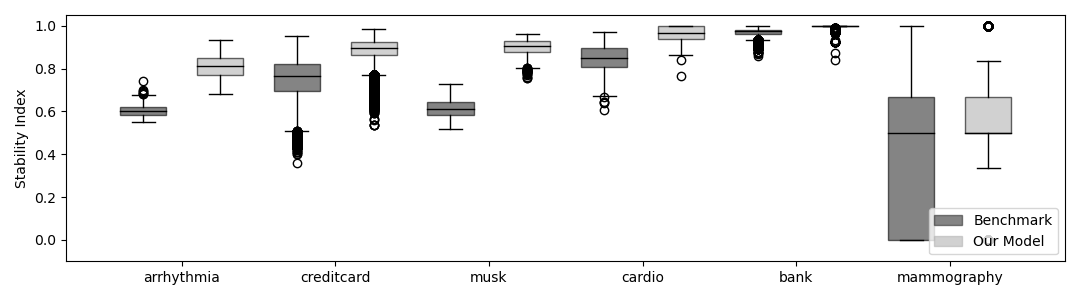

In [9]:
# Example usage
image_1 =  '../boxplots.png'
plot_shap_stab_boxplots(dataframes, df_names)
plt.savefig(image_1, bbox_inches='tight', pad_inches=0.1)  #Save the plot to a file

In [10]:
import pandas as pd
import numpy as np

df_all_list = []  # Use a list to collect DataFrames
df_all = []
df_filter = []

for name in df_names:
    df_benchmark = df_group[(df_group['dataset'] == name) & (df_group['hpo'] == 'Benchmark')].iloc[0]
    df_our_model = df_group[(df_group['dataset'] == name) & (df_group['hpo'] != 'Benchmark')].iloc[0]

    df_filter = df[((df['dataset'] == name) & (df['max_feats'] == int(df_benchmark['max_feats'])) & (df['n_feats'] == int(df_benchmark['n_feats']))) | 
                   ((df['dataset'] == name) & (df['max_feats'] == int(df_our_model['max_feats'])) & (df['n_feats'] == int(df_our_model['n_feats'])))]

    df_filter = df_filter.copy()  # Avoid SettingWithCopyWarning
    df_filter['hpo'] = np.where(((df_filter.max_feats==int(df_benchmark.max_feats)) & (df_filter.n_feats==int(df_benchmark.n_feats))), 'Benchmark', 'Our model')

    df_all_list.append(df_filter)

# Concatenate all DataFrames outside the loop
df_all = pd.concat(df_all_list, ignore_index=True)


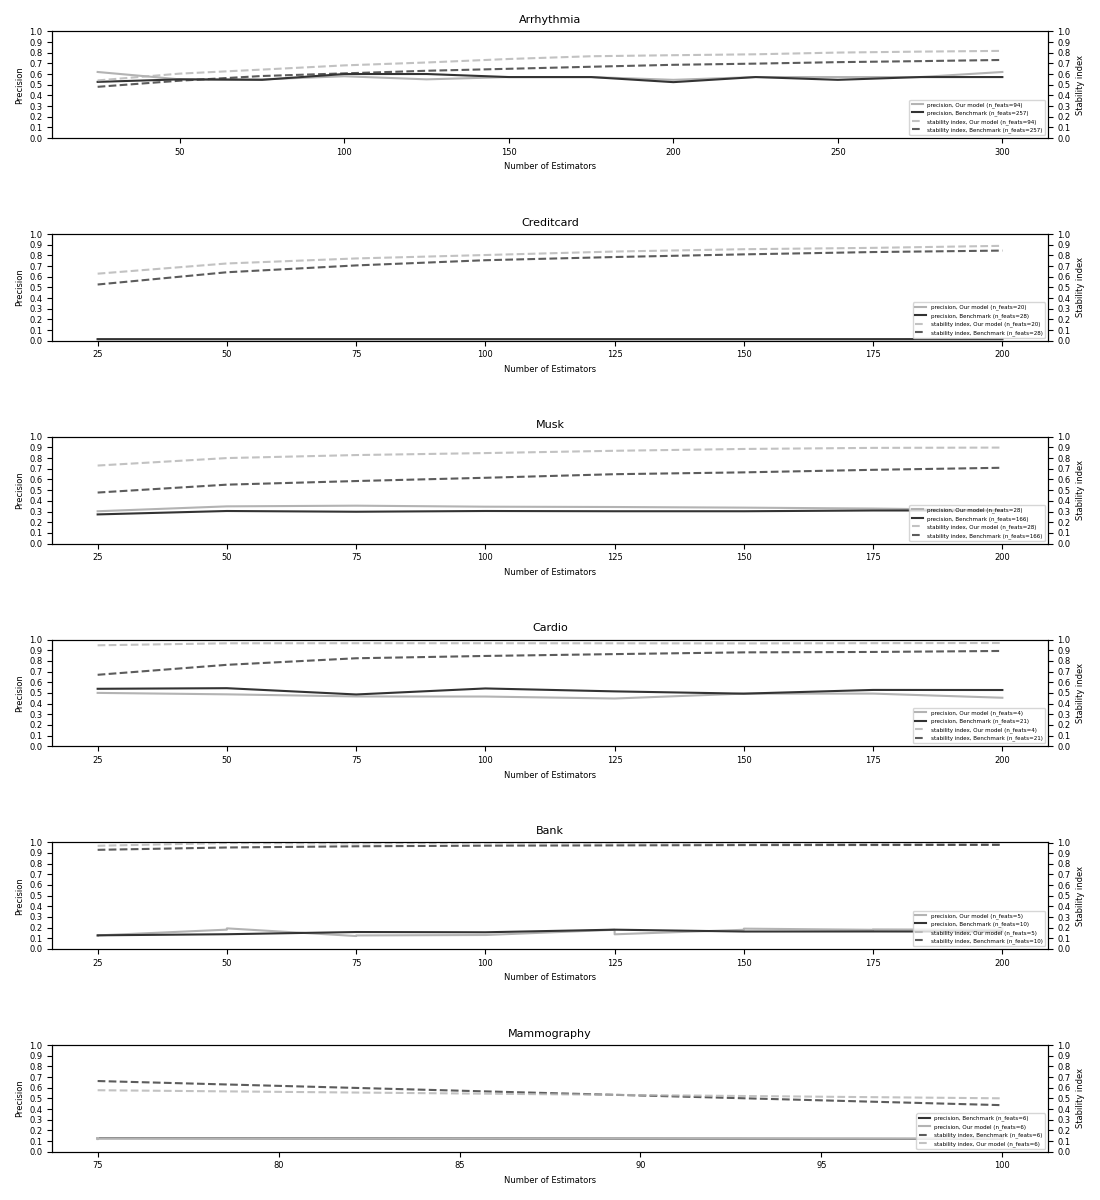

In [11]:
plt.figure(figsize=(11, 12))  # Overall figure size

row = 1
col = 6

# First plot
ax1 = plt.subplot(col, row, 1)
plot_2d_surface(df_all[df_all.dataset==dataset_id1], ax1, primary_feat='precision', secondary_feat='stability index')

ax2 = plt.subplot(col, row, 2)
plot_2d_surface(df_all[df_all.dataset==dataset_id2], ax2, primary_feat='precision', secondary_feat='stability index')

ax3 = plt.subplot(col, row, 3)
plot_2d_surface(df_all[df_all.dataset==dataset_id3], ax3, primary_feat='precision', secondary_feat='stability index')

ax4 = plt.subplot(col, row, 4)
plot_2d_surface(df_all[df_all.dataset==dataset_id4], ax4, primary_feat='precision', secondary_feat='stability index')

ax5 = plt.subplot(col, row, 5)
plot_2d_surface(df_all[df_all.dataset==dataset_id5], ax5, primary_feat='precision', secondary_feat='stability index')

ax6 = plt.subplot(col, row, 6)
plot_2d_surface(df_all[df_all.dataset==dataset_id6], ax6, primary_feat='precision', secondary_feat='stability index')



plt.tight_layout()  # Adjust layout

# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.1, hspace=0.9)  # Adjust the width space as needed for better visualization

image_2 =  '../comparison.png'
plt.savefig(image_2, bbox_inches='tight', pad_inches=0.1)  #Save the plot to a file
#plt.savefig(image_1, bbox_inches='tight', pad_inches=0.3)  # Save the plot to a file
plt.show()

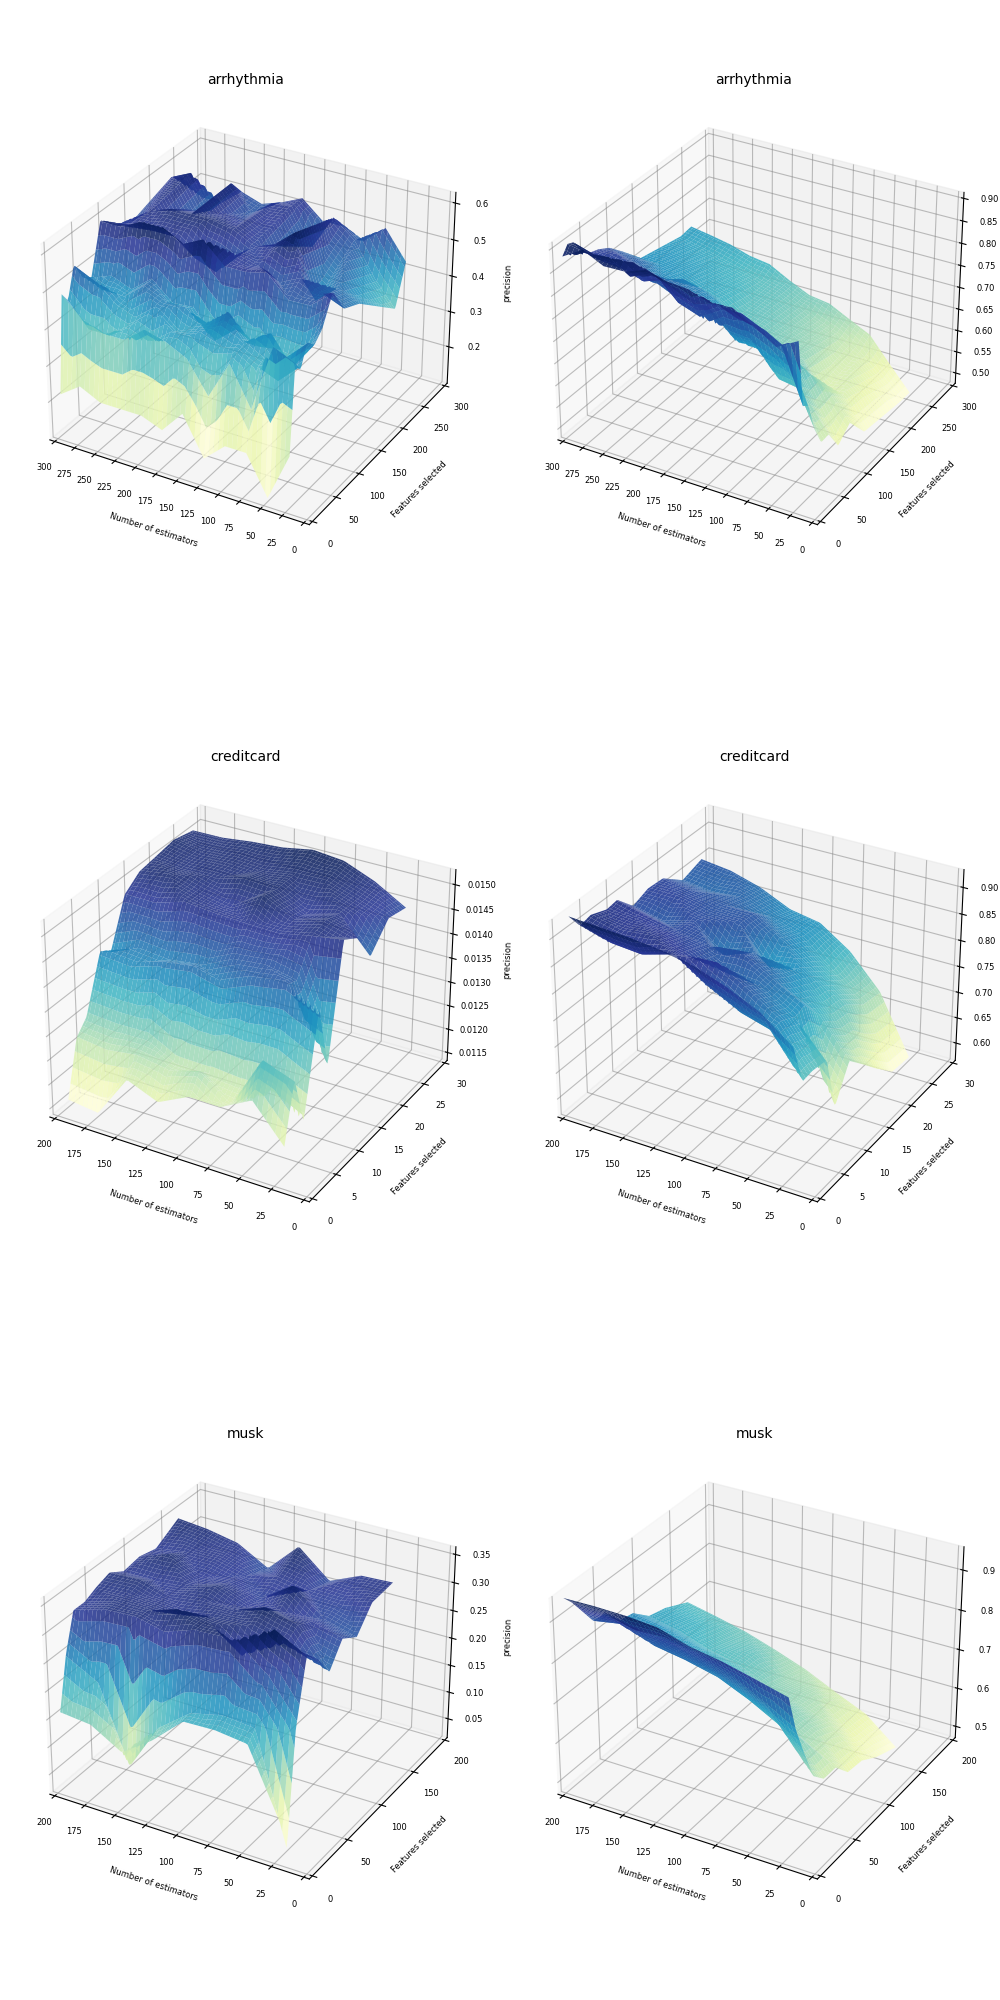

In [12]:
plt.figure(figsize=(10, 20))  # Overall figure size

# First dataset
ax1 = plt.subplot(3, 2, 1, projection='3d')
plot_3d_surface(df1, 'n_estimators', 'n_feats', 'precision', ax1, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=50, opt_color='red', title=f'{dataset_id1}', alpha=0.85, edgecolor=None)
ax2 = plt.subplot(3, 2, 2, projection='3d')
plot_3d_surface(df1, 'n_estimators', 'n_feats', 'stability index', ax2, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=50, opt_color='red', title=f'{dataset_id1}', alpha=.9, edgecolor=None)

# Second dataset
ax1 = plt.subplot(3, 2, 3, projection='3d')
plot_3d_surface(df2, 'n_estimators', 'n_feats', 'precision', ax1, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=5, opt_color='red', title=f'{dataset_id2}', alpha=0.85, edgecolor=None)
ax2 = plt.subplot(3, 2, 4, projection='3d')
plot_3d_surface(df2, 'n_estimators', 'n_feats', 'stability index', ax2, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=5, opt_color='red', title=f'{dataset_id2}', alpha=.9, edgecolor=None)

# Third dataset
ax1 = plt.subplot(3, 2, 5, projection='3d')
plot_3d_surface(df3, 'n_estimators', 'n_feats', 'precision', ax1, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=50, opt_color='red', title=f'{dataset_id3}', alpha=0.85, edgecolor=None)
ax2 = plt.subplot(3, 2, 6, projection='3d')
plot_3d_surface(df3, 'n_estimators', 'n_feats', 'stability index', ax2, fontsize_title=10, fontsize_axes=6, cmap='YlGnBu', x_step=25, y_step=50, opt_color='red', title=f'{dataset_id3}', alpha=.9, edgecolor=None)

plt.tight_layout()  # Adjust layout


# Adjust the spacing between the plots
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust the width space as needed for better visualization

#plt.savefig(image_1, bbox_inches='tight', pad_inches=0.3)  # Save the plot to a file
plt.show()

In [13]:
dataset_id = 'allianz'
#df_names = [dataset_id1, dataset_id2, dataset_id3, dataset_id4, dataset_id5, dataset_id6]

df_real = process_data(dataset_id, data_root)

factor = 1.0
#df_fil_real = filter_and_select(df_real, factor)

var = ['dataset', 'hpo', 'n_estimators', 'max_feats', 'n_feats', 'stability index', 'shap_stab', 'shap_q2', 'model_stab']
#df_group = round(df_fil_real[var],4)

df_graph_real = process_graph_data(df_real)

In [14]:
path_fi_shap = os.path.join(data_root, "outputs", f"{dataset_id}_fi_shap")
fi_shap_all = pd.read_parquet(path_fi_shap)
fi_shap_all

,n_feats,cum_value,cum_value_percentage,n_feats_percentage,feat_selected
0,2,0.471160,10.109160,4.347826,"[C_APPLN_MALUS_1, C_CAU_40]"
1,4,0.914633,19.624280,8.695652,"[C_APPLN_MALUS_1, C_CAU_40, d_surv_sin_is_week..."
2,6,1.332647,28.593162,13.043478,"[C_APPLN_MALUS_1, C_CAU_40, d_surv_sin_is_week..."
3,9,1.923959,41.280298,19.565217,"[C_APPLN_MALUS_1, C_CAU_40, d_surv_sin_is_week..."
4,11,2.287247,49.074969,23.913043,"[C_APPLN_MALUS_1, C_CAU_40, d_surv_sin_is_week..."
5,14,2.782953,59.710800,30.434783,"[C_APPLN_MALUS_1, C_CAU_40, d_surv_sin_is_week..."
6,18,3.307418,70.963679,39.130435,"[C_APPLN_MALUS_1, C_CAU_40, d_surv_sin_is_week..."
7,22,3.727265,79.971873,47.826087,"[C_APPLN_MALUS_1, C_CAU_40, d_surv_sin_is_week..."
8,28,4.216176,90.461924,60.869565,"[C_APPLN_MALUS_1, C_CAU_40, d_surv_sin_is_week..."
9,46,4.660719,100.000000,100.000000,"[C_APPLN_MALUS_1, C_CAU_40, d_surv_sin_is_week..."


In [15]:
group_1 = df_real[var][(df_real.n_estimators==100) & 
                       (df_real.n_feats==df_real.n_feats.max()) & 
                       (df_real.max_feats==df_real.max_feats.max())]

In [16]:
group_2 = df_real[var][(df_real.n_feats==28)].sort_values('stability index', ascending=False).head(1)

In [17]:
df_real[var][(df_real.n_feats==28)].sort_values('stability index', ascending=False)

,dataset,hpo,n_estimators,max_feats,n_feats,stability index,shap_stab,shap_q2,model_stab
425,allianz,Our model,150,5,28,0.969774,"[0.9212728156700984, 0.978222254713163, 0.9678...",0.971923,0.995637
480,allianz,Our model,175,5,28,0.969549,"[0.9347147515838865, 0.9843327547396916, 0.961...",0.972039,0.996200
535,allianz,Our model,200,5,28,0.969349,"[0.9364157811717861, 0.9844041817300392, 0.956...",0.971816,0.996573
370,allianz,Our model,125,5,28,0.968101,"[0.9224534830742314, 0.9737554090375425, 0.956...",0.970401,0.994741
536,allianz,Our model,200,11,28,0.966368,"[0.917805326578595, 0.9786383403644495, 0.9628...",0.967659,0.995290
315,allianz,Our model,100,5,28,0.965470,"[0.9299561435379564, 0.9644525629630689, 0.971...",0.968113,0.993604
537,allianz,Our model,200,16,28,0.964886,"[0.9489201562707384, 0.972408578602038, 0.9692...",0.966291,0.994334
481,allianz,Our model,175,11,28,0.962894,"[0.9161095405028533, 0.9714911971093836, 0.962...",0.964384,0.994730
538,allianz,Our model,200,22,28,0.962218,"[0.9481639921429934, 0.971986524940078, 0.9678...",0.963305,0.995088
482,allianz,Our model,175,16,28,0.961284,"[0.9350459793387059, 0.971853575832736, 0.9654...",0.962886,0.993467


In [18]:
df_group = append_dataframes([group_1, group_2])
df_group

,dataset,hpo,n_estimators,max_feats,n_feats,stability index,shap_stab,shap_q2,model_stab
0,allianz,Benchmark,100,48,48,0.956311,"[0.9561971360006813, 0.9564405765789916, 0.959...",0.956196,0.982390
1,allianz,Our model,150,5,28,0.969774,"[0.9212728156700984, 0.978222254713163, 0.9678...",0.971923,0.995637


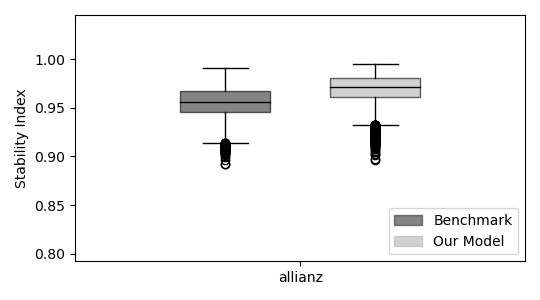

In [19]:
# Example usage
image_1 =  '../boxplots_real.png'
plot_shap_stab_boxplots([df_group], [dataset_id], size=3)
plt.savefig(image_1, bbox_inches='tight', pad_inches=0.1)  #Save the plot to a file

In [20]:
psi = 0.8
gamma = 0.5

In [21]:
beta_param = float((1 / (psi + gamma - 1)) * (2 * gamma - 1 - gamma / 3 + psi * ((3 - 4 * gamma) / 3)))
alpha_param = float(beta_param * ((1 - gamma) / gamma) + (2 * gamma - 1) / gamma)

In [22]:
alpha_param / (alpha_param + beta_param)

0.5

In [23]:
print(alpha_param, beta_param)

0.3333333333333333 0.3333333333333333


In [24]:
norm_list

NameError: name 'norm_list' is not defined

In [ ]:
from scipy.stats import beta

In [ ]:

area

In [ ]:
psi = 0.8
gamma = 0.1

beta_param = float((1 / (psi + gamma - 1)) * (2 * gamma - 1 - gamma / 3 + psi * ((3 - 4 * gamma) / 3)))
alpha_param = float(beta_param * ((1 - gamma) / gamma) + (2 * gamma - 1) / gamma)

list = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
list = [10, 10, 10, 10, 10, 1, 1, 1, 1, 1]
list = [x / len(list) for x in list]
area = beta.cdf(max(list), alpha_param, beta_param) - beta.cdf(min(list), alpha_param, beta_param)
np.std(list) * area

In [ ]:
import numpy as np

# Parameters
nte = 5  # Number of test instances
ft_col_te = 3  # Number of features per test instance
iterations = 2  # Number of iterations

# Initialize the point_rankings array
point_rankings = np.zeros((nte, ft_col_te, iterations), dtype=float)

# Simulate the ranking process
# Assuming arbitrary SHAP values and their rankings for simplicity
for i in range(iterations):
    for j in range(nte):
        # Simulate arbitrary feature rankings for this iteration
        rankings = np.random.permutation(ft_col_te) + 1  # +1 to make rankings start from 1 instead of 0
        for si in range(ft_col_te):
            point_rankings[j, si, i] = rankings[si]

point_rankings
